Bottom Resuspension Problem Script :D

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature



import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Load 'mbathy', 'salinity' and 'U velocity'

In [2]:
path_sal = '/results2/SalishSea/nowcast-green.202111/06aug15/SalishSea_1h_20150806_20150806_grid_T.nc'

In [3]:
path_bat = '/home/sallen/MEOPAR/grid/mesh_mask202108.nc'

In [4]:
mbathy = xr.open_dataset(path_bat)['mbathy'][0]
sal = xr.open_dataset(path_sal)['vosaline']
mask = xr.open_dataset(path_bat)['tmask'][0]

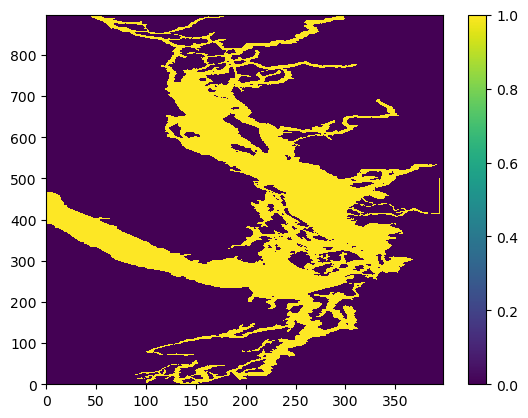

In [5]:
plt.pcolormesh(mask[0,:,:])
plt.colorbar()

Get the land mask right for the salinity dataset

In [6]:
x_l = 398
y_l = 898
depth = 40

In [7]:
gridY = sal['y'].values
gridX = sal['x'].values
tmask = 1 - mask[:, min(gridY):max(gridY)+1, min(gridX):max(gridX)+1]

In [8]:
new_sal = sal.copy()

In [9]:
for d in range(len(sal['deptht'])):
    for i in range(len(sal['time_counter'])):
        new_sal[i,d,:,:] = np.ma.masked_array(sal[i,d,:,:], mask=tmask[d])

NOTES:

- Z are the Z levels from 0 to 40, while deptht is the actual depth of the Z level

- mbathy is the length of the last grid cell

Text(0.5, 1.0, 'mbathy')

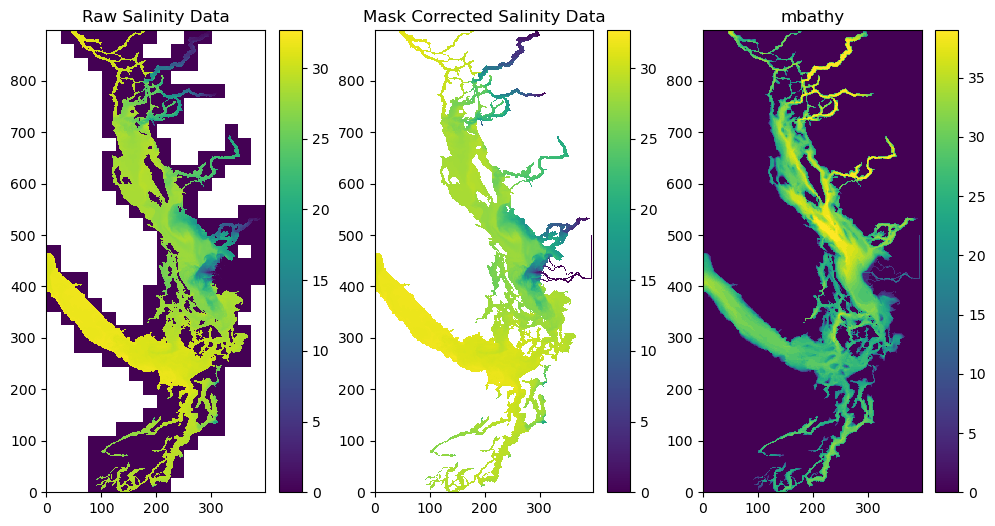

In [10]:
dd = 0
fig, ax = plt.subplots(1,3, figsize = (12,6))
a = ax[0].pcolormesh(sal[0,dd,:,:])
plt.colorbar(a, ax = ax[0])
ax[0].set_title('Raw Salinity Data')
#
b = ax[1].pcolormesh(new_sal[0,dd,:,:])
plt.colorbar(b, ax = ax[1])
ax[1].set_title('Mask Corrected Salinity Data')
#
c = ax[2].pcolormesh(mbathy)
plt.colorbar(c, ax = ax[2])
ax[2].set_title('mbathy')
#


I shouldn't add the mask, since this will change the index that I'm looking for...

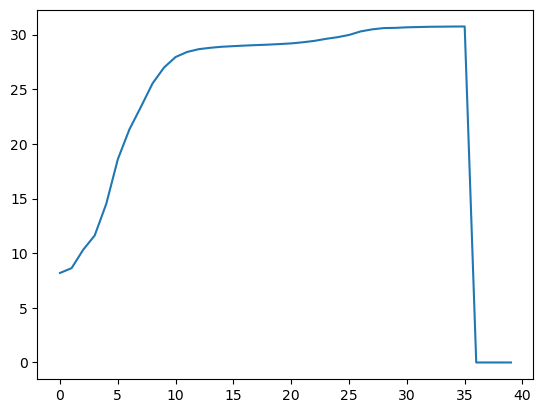

In [11]:
x, y = 255, 840
plt.plot(sal[0,:,y,x])

In [12]:
idx_d = np.where(sal[2,:,y,x] == 0)[0][0]
idx_d

36

In [13]:
mbathy[y,x].values

array(36, dtype=int16)

if the difference is zero between indexes, it means that mbathy and the 'salinity based bottom mask' share the same index for the last water grid cell

In [14]:
idx_d - mbathy[y,x].values

0

In [15]:
aa = np.where(sal[0,:,0,0] == 0)[0]
empty = aa.size == 0
empty

True

Looping takes a lot of time...try just a few timesteps and then optimize the code

In [38]:
dims = ['time_counter', 'y', 'x']
time = np.array(sal['time_counter'], dtype='datetime64')
y = sal['y']
x = sal['x']
#
data = np.empty((len(time), len(y), len(x)))
#
index_array = xr.DataArray(data, dims=dims, coords={'time_counter': time, 'y': y, 'x': x})

In [25]:
for t in range(3):
    #index_array[t, :, :] = np.nan
#for t in range(len(sal['time_counter'])):    
    for j in range(len(sal['y'])):
        for i in range(len(sal['x'])):
            idx_d = np.where(sal[t, :, j, i] == 0)[0]
            #            
            if idx_d.size != 0:
                mbathy_value = mbathy[j, i].values
                diff = idx_d[0] - mbathy_value
                #    
                if diff == 0: 
                    index_array [t, j, i] = mbathy_value
                else:
                    index_array[t, j, i] = idx_d[0]

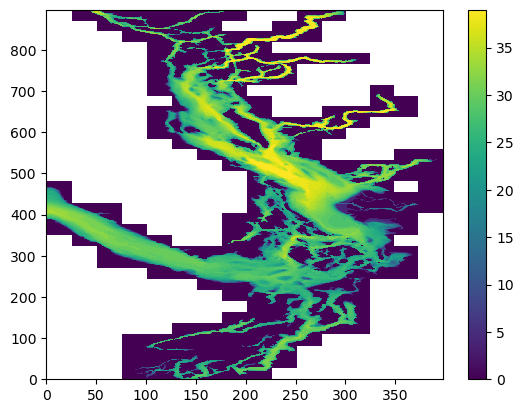

In [35]:
plt.pcolormesh(index_array[0])
plt.colorbar()

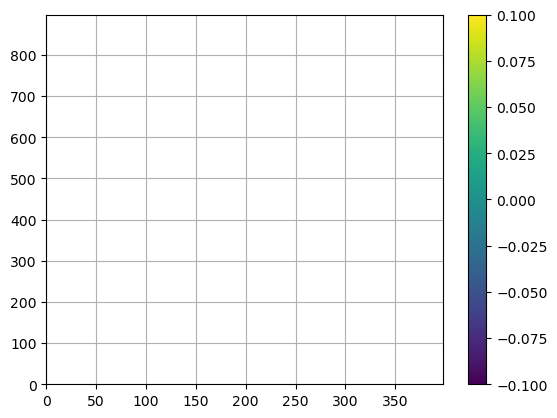

In [27]:
plt.pcolormesh(np.abs(np.subtract(index_array[0], index_array[1])))
plt.grid()
plt.colorbar()

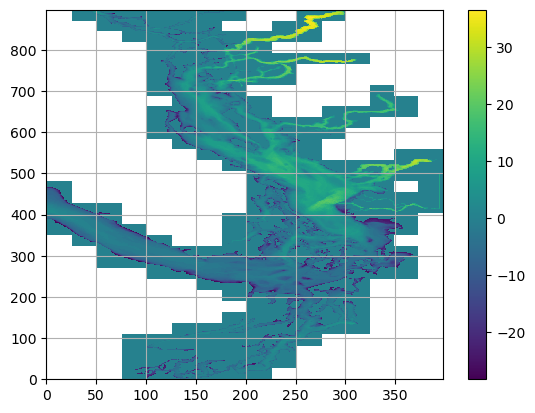

In [21]:
# this plot means that the deepest grid cell is not always the same between mbathy and the salinity grid through time.
# This by assuming that where salinity is 0, then we assume that's bottom.
plt.pcolormesh(np.subtract(mbathy, index_array[2]))
plt.grid()
plt.colorbar()

In [22]:
mbathy

<xarray.DataArray 'mbathy' (y: 898, x: 398)> Size: 715kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Dimensions without coordinates: y, x
Attributes:
    standard_name:  mbathy
    long_name:      fortran index of deepest water cell, T-grid
    units:          count

In [ ]:
#mask = xr.open_dataset(path_bat)

In [ ]:
#mask.e3t_0[0,mbathy[897,397],mbathy.y[897],mbathy.x[397]].values